# Deep Learning: Data Augmentation with ASL dataset
> AHSNCCU/NTNU CSIE 王修佑

資料增強<br>
+ 增加資料集的大小和變異數
+ 選出對分類有用的特徵，讓模型具備更出色的歸納能力

<img src="images/資料增強.png" width=400 />

## 準備資料

In [1]:
import tensorflow.keras as keras
import pandas as pd

# Load in our data from CSV files
train_df = pd.read_csv("asl/sign_mnist_train.csv")
valid_df = pd.read_csv("asl/sign_mnist_valid.csv")

# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# Separate our our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

# Reshape the image data for the convolutional network
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

## 模型建立

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

## 資料增強

運用Keras `ImageDataGenerator`

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)  

為何我們要水平翻轉影像，而不是垂直翻轉？

## 批次大小
`ImageDataGenerator`批次處理我們的資料，讓模型能以隨機的樣本進行訓練。

模型隨機採取資料中一小部分樣本，即可代表所有資料

> 批次大小為 32 和 64 的效果比較理想

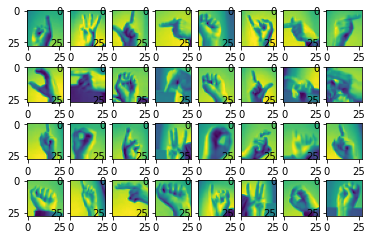

In [4]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

## 將資料擬合生成器

In [5]:
datagen.fit(x_train)

## 編譯模型

In [6]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

## 透過增強進行訓練

+ 傳遞 `x_train`、`y_train` 與 **生成器**到模型
+ 生成器(Generator)生成增強影像
+ 記得要設定Epoch時間
+ Keras [Flow](https://keras.io/api/preprocessing/image/)方法

`steps * batch_size = number_of_images_trained in an epoch`

執行下列儲存格以查看結果。訓練時間比先前更長，畢竟我們現在比之前使用更多資料進行訓練。

In [7]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()
        
callbacks_list = [PlotLearning()]

#callbacks=callbacks_list

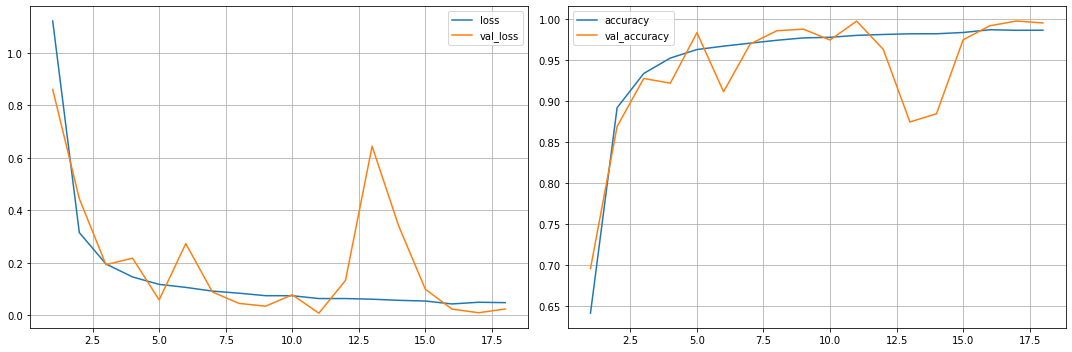

857/857 [==============================] - 38s 45ms/step - loss: 0.0478 - accuracy: 0.9862 - val_loss: 0.0235 - val_accuracy: 0.9950
Epoch 19/20
857/857 [============================>.] - ETA: 0s - loss: 0.0460 - accuracy: 0.9865

In [ ]:
model.fit(img_iter,
          epochs=20,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_valid, y_valid),
          callbacks=callbacks_list)

## 結果討論

驗證正確率提升了~  
解決了Overfitting!

## 儲存模型

+ 使用 save 方法將模型儲存在 Keras。
> [說明文件](https://www.tensorflow.org/guide/keras/save_and_serialize)
+ 各框架常用模型格式
    + ONNX (.onnx, .pb, .pbtxt)
    + Keras (.h5, .keras)
    + Core ML (.mlmodel)
    + Caffe2 (predict_net.pb, predict_net.pbtxt)
    + MXNet (.model, -symbol.json) 
    + TensorFlow Lite (.tflite). 
    + Caffe (.caffemodel, .prototxt)
    + PyTorch (.pt, .pth)
    + TorchScript (.pt, .pth)
    + Torch (.t7), CNTK (.model, .cntk)
    + PaddlePaddle (__model__)
    + Darknet (.cfg)
    + NCNN (.param)
    + scikit-learn (.pkl)
    + TensorFlow.js (model.json, .pb)
    + TensorFlow (.pb, .meta, .pbtxt)

In [ ]:
model.save('asl_model')

### 清除記憶體

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)